<a href="https://colab.research.google.com/github/ankesh86/BlueBikes_MachineLearning/blob/main/BlueBikesData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [5]:
import requests
import zipfile
import pandas as pd
import os

# List of dates
Dates = [202201, 202202, 202203, 202204, 202205, 202206, 202207, 202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308, 202309, 202310, 202311, 202312, 202401, 202402, 202403, 202404, 202405]

# Initialize an empty list to store dataframes
dataframes = []

for i in Dates:
    file_name = str(i) + '-bluebikes-tripdata.csv'
    url = f'https://s3.amazonaws.com/hubway-data/{i}-bluebikes-tripdata.zip'

    # Send a request to download the zip file
    response = requests.get(url)
    zip_path = f"{i}-bluebikes-tripdata.zip"

    # Write the contents of the download to a zip file
    with open(zip_path, "wb") as f:
        f.write(response.content)

    # Unzip the file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("unzipped_data")

    # Load the CSV file into a DataFrame
    csv_path = os.path.join("unzipped_data", file_name)
    df = pd.read_csv(csv_path, encoding='utf-8')

    # Check if the DataFrame needs column renaming and adjustments
    if 'starttime' in df.columns:
        # Rename columns to align with the newer format
        df.rename(columns={'starttime': 'started_at',
                           'stoptime': 'ended_at',
                           'usertype': 'member_casual'}, inplace=True)
    dataframes.append(df)

    # Clean up the files from the disk if not needed
    os.remove(zip_path)
    os.remove(csv_path)

# Concatenate all the dataframes into a single dataframe
final_df = pd.concat(dataframes, ignore_index=True)
raw_data = final_df[["started_at", "ended_at", "member_casual"]]
# Set options to display all columns
pd.set_option('display.max_columns', None)

# Check the concatenated DataFrame
print(raw_data.head())


                 started_at                  ended_at member_casual
0  2022-01-01 00:00:25.1660  2022-01-01 00:10:22.1920    Subscriber
1  2022-01-01 00:00:40.4300  2022-01-01 00:07:32.1980    Subscriber
2  2022-01-01 00:00:54.8180  2022-01-01 00:08:51.6680      Customer
3  2022-01-01 00:01:01.6080  2022-01-01 00:08:48.2350      Customer
4  2022-01-01 00:01:06.0520  2022-01-01 00:13:38.2300    Subscriber


In [7]:
raw_data.shape

(8907668, 3)

In [ ]:
URLA = 'https://s3.amazonaws.com/hubway-data/202404-bluebikes-tripdata.zip'
URLB = 'https://s3.amazonaws.com/hubway-data/202405-bluebikes-tripdata.zip'
from zipfile import ZipFile
zf = ZipFile(URLB, 'r')
zf.extractall('sample_data')
zf.close()

raw_data = pd.read_csv('202405-bluebikes-tripdata.csv', encoding='utf-8')
raw_data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,2223D2584B189BDA,classic_bike,2024-05-29 13:40:33,2024-05-29 13:59:41,Bowdoin St at Quincy St,B32031,Christian Science Plaza - Massachusetts Ave at...,B32005,42.307852,-71.065122,42.343666,-71.085824,member
1,96EA32F96F1EDB68,classic_bike,2024-05-09 18:28:25,2024-05-09 18:36:00,Mugar Way at Beacon St,D32017,Blossom St at Charles St,D32050,42.355536,-71.072869,42.364356,-71.069594,member
2,FA3D2E0C93FC6106,classic_bike,2024-05-02 14:57:16,2024-05-02 15:07:48,Brookline Village - Station Street at MBTA,K32003,Landmark Center - Brookline Ave at Park Dr,B32015,42.332744,-71.116267,42.343691,-71.102353,casual
3,1B06C3F3908BFF50,classic_bike,2024-05-02 17:28:58,2024-05-02 17:44:19,Mugar Way at Beacon St,D32017,Landmark Center - Brookline Ave at Park Dr,B32015,42.355536,-71.072869,42.343691,-71.102353,casual
4,EDBDA5B466F9CE2E,classic_bike,2024-05-15 17:37:02,2024-05-15 17:45:09,Brookline Village - Station Street at MBTA,K32003,Marion St at Harvard St,K32012,42.332744,-71.116267,42.340122,-71.120706,member


In [8]:
print(raw_data.info())
print(raw_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8907668 entries, 0 to 8907667
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   started_at     object
 1   ended_at       object
 2   member_casual  object
dtypes: object(3)
memory usage: 203.9+ MB
None
started_at       0
ended_at         0
member_casual    0
dtype: int64


In [10]:
#preprocessing

raw_data_cleaned = raw_data.dropna()
# Assuming raw_data_cleaned is a slice from another DataFrame
raw_data_cleaned = raw_data_cleaned.copy()
#raw_data_cleaned['started_at'] = raw_data_cleaned['started_at'].astype('datetime64[ns]')
#raw_data_cleaned['ended_at'] = raw_data_cleaned['ended_at'].astype('datetime64[ns]')
raw_data_cleaned['started_at'] = pd.to_datetime(raw_data_cleaned['started_at'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')
raw_data_cleaned['ended_at'] = pd.to_datetime(raw_data_cleaned['ended_at'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')


raw_data_cleaned['ride_duration'] = raw_data_cleaned['ended_at'] - raw_data_cleaned['started_at']

raw_data_cleaned['ride_duration_hours'] = raw_data_cleaned['ride_duration'].dt.total_seconds() / 3600
raw_data_cleaned['ride_duration_minutes'] = raw_data_cleaned['ride_duration'].dt.total_seconds() / 60
raw_data_cleaned['ride_duration_seconds'] = raw_data_cleaned['ride_duration'].dt.total_seconds()

#replacing negative hours data with 0
# Keep only rows where the ride duration is non-negative
raw_data_cleaned = raw_data_cleaned[raw_data_cleaned['ride_duration_hours'] >= 0]

print(raw_data_cleaned.head(5))

               started_at                ended_at member_casual  \
0 2022-01-01 00:00:25.166 2022-01-01 00:10:22.192    Subscriber   
1 2022-01-01 00:00:40.430 2022-01-01 00:07:32.198    Subscriber   
2 2022-01-01 00:00:54.818 2022-01-01 00:08:51.668      Customer   
3 2022-01-01 00:01:01.608 2022-01-01 00:08:48.235      Customer   
4 2022-01-01 00:01:06.052 2022-01-01 00:13:38.230    Subscriber   

           ride_duration  ride_duration_hours  ride_duration_minutes  \
0 0 days 00:09:57.026000             0.165841               9.950433   
1 0 days 00:06:51.768000             0.114380               6.862800   
2 0 days 00:07:56.850000             0.132458               7.947500   
3 0 days 00:07:46.627000             0.129619               7.777117   
4 0 days 00:12:32.178000             0.208938              12.536300   

   ride_duration_seconds  
0                597.026  
1                411.768  
2                476.850  
3                466.627  
4                752.178  


In [11]:
# Correctly setting the 'ended_at' column to datetime format using .loc
print(raw_data_cleaned.dtypes)
print(raw_data_cleaned.shape)


started_at                datetime64[ns]
ended_at                  datetime64[ns]
member_casual                     object
ride_duration            timedelta64[ns]
ride_duration_hours              float64
ride_duration_minutes            float64
ride_duration_seconds            float64
dtype: object
(4249599, 7)


In [14]:
raw_data_cleaned['member_casual'] = raw_data_cleaned['member_casual'].replace('Subscriber', 'member')
raw_data_cleaned['member_casual'] = raw_data_cleaned['member_casual'].replace('Customer', 'casual')
raw_data_cleaned.head()

,started_at,ended_at,member_casual,ride_duration,ride_duration_hours,ride_duration_minutes,ride_duration_seconds
0,2022-01-01 00:00:25.166,2022-01-01 00:10:22.192,member,0 days 00:09:57.026000,0.165841,9.950433,597.026
1,2022-01-01 00:00:40.430,2022-01-01 00:07:32.198,member,0 days 00:06:51.768000,0.114380,6.862800,411.768
2,2022-01-01 00:00:54.818,2022-01-01 00:08:51.668,casual,0 days 00:07:56.850000,0.132458,7.947500,476.850
3,2022-01-01 00:01:01.608,2022-01-01 00:08:48.235,casual,0 days 00:07:46.627000,0.129619,7.777117,466.627
4,2022-01-01 00:01:06.052,2022-01-01 00:13:38.230,member,0 days 00:12:32.178000,0.208938,12.536300,752.178


In [15]:
gathered_data = raw_data_cleaned[["started_at", "member_casual", "ride_duration_seconds"]]
gathered_data

,started_at,member_casual,ride_duration_seconds
0,2022-01-01 00:00:25.166,member,597.026
1,2022-01-01 00:00:40.430,member,411.768
2,2022-01-01 00:00:54.818,casual,476.850
3,2022-01-01 00:01:01.608,casual,466.627
4,2022-01-01 00:01:06.052,member,752.178
...,...,...,...
4249594,2023-03-31 23:55:01.558,casual,322.268
4249595,2023-03-31 23:55:24.138,member,748.167
4249596,2023-03-31 23:58:04.497,member,1071.527
4249597,2023-03-31 23:58:37.652,member,1096.060


In [11]:
#classical_bike_df = gathered_data[gathered_data['rideable_type'] == 'classic_bike']
#electric_bike_df = gathered_data[gathered_data['rideable_type'] == 'electric_bike']

In [16]:
gathered_data.shape

(4249599, 3)

In [82]:
import datetime

bike_df = gathered_data.copy()
#classical_bike_df.loc[:, 'date'] = classical_bike_df['started_at'].dt.date

#classical_bike_df['started_at_parsed'] = classical_bike_df['started_at'].dt.strftime('%Y-%m-%d %H')
bike_df['started_at_time'] = pd.to_datetime(bike_df['started_at'].dt.strftime('%Y-%m-%d %H'))



#classical_bike_df['started_at_parsed'] = classical_bike_df['started_at'].apply(parse)

bike_df.drop('started_at', axis=1, inplace=True)

In [83]:
bike_df.head()

,member_casual,ride_duration_seconds,started_at_time
0,member,597.026,2022-01-01
1,member,411.768,2022-01-01
2,casual,476.850,2022-01-01
3,casual,466.627,2022-01-01
4,member,752.178,2022-01-01


In [84]:
aggregated_df = bike_df.pivot_table(
    index='started_at_time',
    columns='member_casual',
    values='ride_duration_seconds',
    aggfunc={
        'ride_duration_seconds': ['count', 'sum']
    }
)

# Flatten the multi-level column names and rename them
aggregated_df.columns = ['_'.join(col).strip() for col in aggregated_df.columns.values]
aggregated_df = aggregated_df.rename(columns={
    'ride_duration_seconds_count_casual': 'casual_count',
    'ride_duration_seconds_sum_casual': 'casual_duration_sum',
    'ride_duration_seconds_count_member': 'member_count',
    'ride_duration_seconds_sum_member': 'member_duration_sum'
})

# Reset index to make 'started_at_time' a column again
aggregated_df = aggregated_df.fillna(0)
aggregated_df.reset_index(inplace=True)

In [85]:
from holidays import country_holidays
us_holidays = country_holidays('US')
# For a specific subdivision (e.g. state or province):
mass_holidays = country_holidays('US', subdiv='MA')

In [86]:
aggregated_df['count'] = aggregated_df['count_casual'] + aggregated_df['count_member']
aggregated_df['travel_time'] = aggregated_df['sum_casual'] + aggregated_df['sum_member']
aggregated_df['day_of_week'] = aggregated_df['started_at_time'].dt.day_name().str.upper()
# Create a new column 'IsWeekend' by checking if the day of the week is Saturday (5) or Sunday (6)
aggregated_df['IsWeekend'] = aggregated_df['started_at_time'].dt.weekday.apply(lambda x: 1 if x in (5, 6) else 0)
# Create 'IsHoliday' column
aggregated_df['IsHoliday'] = aggregated_df['started_at_time'].dt.date.apply(lambda x: 1 if x in mass_holidays else 0)

aggregated_df.head()

,started_at_time,count_casual,count_member,sum_casual,sum_member,count,travel_time,day_of_week,IsWeekend,IsHoliday
0,2022-01-01 00:00:00,28.0,97.0,554670.352,96500.233,125.0,651170.585,SATURDAY,1,1
1,2022-01-01 01:00:00,31.0,61.0,46275.121,58476.136,92.0,104751.257,SATURDAY,1,1
2,2022-01-01 02:00:00,32.0,41.0,377841.592,45188.936,73.0,423030.528,SATURDAY,1,1
3,2022-01-01 03:00:00,54.0,41.0,2537735.255,37166.140,95.0,2574901.395,SATURDAY,1,1
4,2022-01-01 04:00:00,49.0,42.0,911447.615,43173.366,91.0,954620.981,SATURDAY,1,1


# **Weather Data Collection**

In [27]:
!pip -q install meteostat

In [67]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Hourly

# Set time period
start = datetime(2022, 1, 1)
end = datetime(2024, 5, 31)

# Create Point for Boston, MA
location = Point(42.3601, -71.0589)

# Get daily data for 2018
temp_data = Hourly(location, start, end)
temp_data = temp_data.fetch()

#temp(celsius), humidity, wind_speed (km/h), pressure(hPa), weather_condition
temp_data = temp_data[['temp','rhum','wspd','pres','coco']]
# Replace NaN values in 'coco' column with 1
temp_data['coco'] = temp_data['coco'].fillna(2)


### Weather Dataset Abbreviations

- **temp**: Temperature - Usually measured in degrees Celsius or Fahrenheit.
- **dwpt**: Dew Point - This is the temperature to which air must be cooled to become saturated with water vapor, indicating when dew (or frost at lower temperatures) would form.
- **rhum**: Relative Humidity - Expressed as a percentage, this measures the amount of water vapor present in the air relative to the maximum amount of water vapor the air can hold at that temperature.
- **prcp**: Precipitation - The amount of rain, snow, sleet, or other forms of water that falls, typically measured in millimeters or inches.
- **snow**: Snowfall - The amount of snow precipitation, often measured in inches or centimeters.
- **wdir**: Wind Direction - Indicates the direction from which the wind is coming, typically measured in degrees from true north.
- **wspd**: Wind Speed - The speed of the wind, often measured in kilometers per hour or miles per hour.
- **wpgt**: Wind Gust - The peak speed of the wind during a particular period, also measured in kilometers per hour or miles per hour.
- **pres**: Atmospheric Pressure - The force exerted by the atmosphere at a point, measured in millibars (mb) or hectopascals (hPa).
- **tsun**: Sunshine Duration - The total number of hours when the sun is shining and not obscured by clouds, measured in hours or minutes.
- **coco**: Weather Condition Code - A numeric or symbolic code that describes the general weather conditions (clear, cloudy, rain, etc.).


In [71]:
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21145 entries, 2022-01-01 00:00:00 to 2024-05-31 00:00:00
Freq: H
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    21145 non-null  float64
 1   rhum    21145 non-null  float64
 2   wspd    21145 non-null  float64
 3   pres    21145 non-null  float64
 4   coco    21145 non-null  float64
dtypes: float64(5)
memory usage: 991.2 KB


In [80]:
# Define specific weather conditions
specific_conditions = {
    1: "Clear",
    2: "Fair",
    3: "Cloudy",
    4: "Overcast",
    5: "Fog",
    6: "Freezing Fog",
    7: "Light Rain",
    8: "Rain",
    9: "Heavy Rain",
    10: "Freezing Rain",
    11: "Heavy Freezing Rain",
    12: "Sleet",
    13: "Heavy Sleet",
    14: "Light Snowfall",
    15: "Snowfall",
    16: "Heavy Snowfall",
    17: "Rain Shower",
    18: "Heavy Rain Shower",
    19: "Sleet Shower",
    20: "Heavy Sleet Shower",
    21: "Snow Shower",
    22: "Heavy Snow Shower",
    23: "Lightning",
    24: "Hail",
    25: "Thunderstorm",
    26: "Heavy Thunderstorm",
    27: "Storm"
}

# Categorize specific conditions into broader categories
weather_categories = {
    "Clear": ["Clear"],
    "Fair": ["Fair"],
    "Cloudy": ["Cloudy", "Overcast", "Fog", "Freezing Fog"],
    "Rain": ["Light Rain", "Rain", "Heavy Rain", "Freezing Rain", "Heavy Freezing Rain", "Rain Shower", "Heavy Rain Shower"],
    "Snow": ["Sleet", "Heavy Sleet", "Light Snowfall", "Snowfall", "Heavy Snowfall", "Sleet Shower", "Heavy Sleet Shower", "Snow Shower", "Heavy Snow Shower"],
    "Thunderstorm": ["Lightning", "Hail", "Thunderstorm", "Heavy Thunderstorm", "Storm"]
}

# Convert specific conditions to general categories
general_weather = {code: next(category for category, conditions in weather_categories.items() if specific_conditions[code] in conditions) for code in specific_conditions}

# Replace the numerical codes in 'coco' with weather condition descriptions
temp_data['weather_condition'] = temp_data['coco'].map(general_weather)

# Check the first few rows to see the updated 'weather_condition' column
print(temp_data.head())


                     temp  rhum  wspd    pres  coco weather_condition
time                                                                 
2022-01-01 00:00:00   6.7  89.0   7.6  1014.9   4.0            Cloudy
2022-01-01 01:00:00   6.7  89.0   7.6  1014.7   4.0            Cloudy
2022-01-01 02:00:00   6.7  89.0   7.6  1014.7   5.0            Cloudy
2022-01-01 03:00:00   6.7  96.0   5.4  1014.2   5.0            Cloudy
2022-01-01 04:00:00   7.2  93.0   5.4  1014.4   5.0            Cloudy


#Merging the datasets Bike Data and Weather Data

In [87]:
aggregated_df.set_index('started_at_time', inplace=True)

# Join the DataFrame with temp_data
# Assuming temp_data is already indexed by datetime
combined_data = aggregated_df.join(temp_data, how='inner')  # 'inner' join to keep only matching index entries

# Check the first few rows to see the combined DataFrame
print(combined_data.head())

                     count_casual  count_member   sum_casual  sum_member  \
2022-01-01 00:00:00          28.0          97.0   554670.352   96500.233   
2022-01-01 01:00:00          31.0          61.0    46275.121   58476.136   
2022-01-01 02:00:00          32.0          41.0   377841.592   45188.936   
2022-01-01 03:00:00          54.0          41.0  2537735.255   37166.140   
2022-01-01 04:00:00          49.0          42.0   911447.615   43173.366   

                     count  travel_time day_of_week  IsWeekend  IsHoliday  \
2022-01-01 00:00:00  125.0   651170.585    SATURDAY          1          1   
2022-01-01 01:00:00   92.0   104751.257    SATURDAY          1          1   
2022-01-01 02:00:00   73.0   423030.528    SATURDAY          1          1   
2022-01-01 03:00:00   95.0  2574901.395    SATURDAY          1          1   
2022-01-01 04:00:00   91.0   954620.981    SATURDAY          1          1   

                     temp  rhum  wspd    pres  coco weather_condition  
2022-01-

In [89]:
# Rename columns in the DataFrame
combined_data.rename(columns={
    'count_casual': 'casual_riders_count',
    'count_member': 'member_riders_count',
    'sum_casual':'casual_rider_duration',
    'sum_member':'member_rider_duration',
    'temp': 'Temp(c)',
    'rhum': 'rel_humidity',
}, inplace=True)

combined_data.to_csv('bluebike_data.csv', sep=',', columns=['casual_riders_count','member_riders_count','casual_rider_duration','member_rider_duration','count','travel_time','day_of_week','IsWeekend','IsHoliday','Temp(c)','rel_humidity','wspd','pres','weather_condition'], header=True, index=True, encoding='utf-8')

# **Visuals**

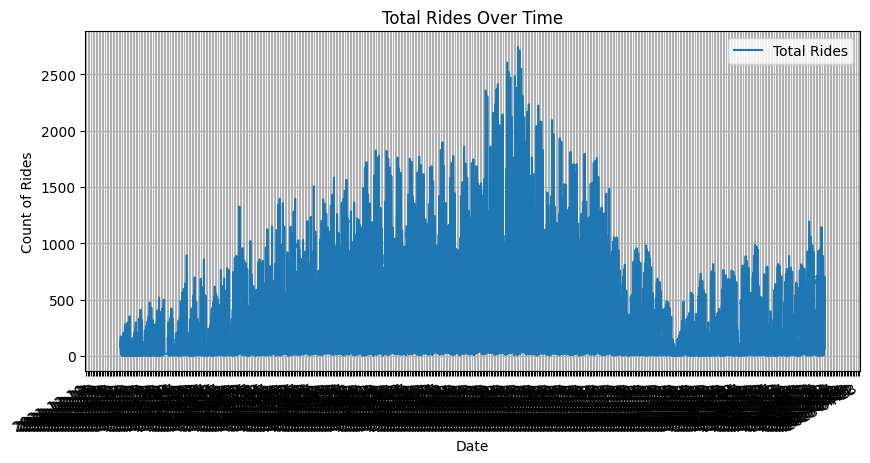

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting the time series data
plt.figure(figsize=(10, 5))  # Set the figure size for better readability
plt.plot(aggregated_df['started_at_time'], aggregated_df['count'], label='Total Rides')  # Add a label for the legend

# Formatting the date on the x-axis to make it more readable
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Set major ticks to be one day apart
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date display
plt.gcf().autofmt_xdate()  # Auto format the dates to prevent overlap

plt.title('Total Rides Over Time')  # Add a title to the plot
plt.xlabel('Date')  # Label the x-axis
plt.ylabel('Count of Rides')  # Label the y-axis
plt.legend(loc='best')  # Ensure the legend is placed in the best location
plt.grid(True)  # Add a grid for easier reading of values

plt.show()  # Display the plot

# **Seasonality Trend**

In [23]:
#seasonality
seasonality_df = aggregated_df[['started_at_time','count']]

# Check if the DataFrame has only one column and convert to Series if true
if len(seasonality_df.columns) == 1:
    data = seasonality_df.iloc[:, 0]
else:
    data = seasonality_df

# Show the first few rows of the data
print(data.head())


      started_at_time  count
0 2022-01-01 00:00:00  125.0
1 2022-01-01 01:00:00   92.0
2 2022-01-01 02:00:00   73.0
3 2022-01-01 03:00:00   95.0
4 2022-01-01 04:00:00   91.0


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn for enhanced visualizations
import calendar

# Ensure 'started_at_time' is in datetime format if not already
seasonality_df = aggregated_df[['started_at_time','count']]

seasonality_df = seasonality_df.copy()
# Extract hour and date from 'started_at_time'
seasonality_df['hour'] = seasonality_df['started_at_time'].dt.hour
seasonality_df['date'] = seasonality_df['started_at_time'].dt.date
#seasonality_df['day_of_week'] = seasonality_df['started_at_time'].dt.day_of_week

# Ensure 'date' is in datetime format if not already
seasonality_df['date'] = pd.to_datetime(seasonality_df['date'])
# Create a new column 'day_of_week' to store the name of the weekday
seasonality_df['day_of_week'] = seasonality_df['date'].dt.day_name().str.upper()

# Display the first few rows to verify
print(seasonality_df.head())


      started_at_time  count  hour       date day_of_week
0 2022-01-01 00:00:00  125.0     0 2022-01-01    SATURDAY
1 2022-01-01 01:00:00   92.0     1 2022-01-01    SATURDAY
2 2022-01-01 02:00:00   73.0     2 2022-01-01    SATURDAY
3 2022-01-01 03:00:00   95.0     3 2022-01-01    SATURDAY
4 2022-01-01 04:00:00   91.0     4 2022-01-01    SATURDAY


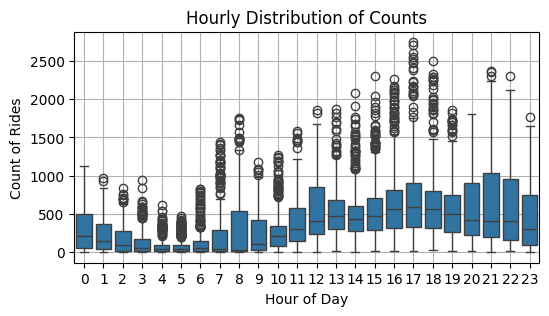

In [25]:
plt.figure(figsize=(6, 3))
sns.boxplot(x='hour', y='count', data=seasonality_df)
plt.title('Hourly Distribution of Counts')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Rides')
plt.grid(True)
plt.show()

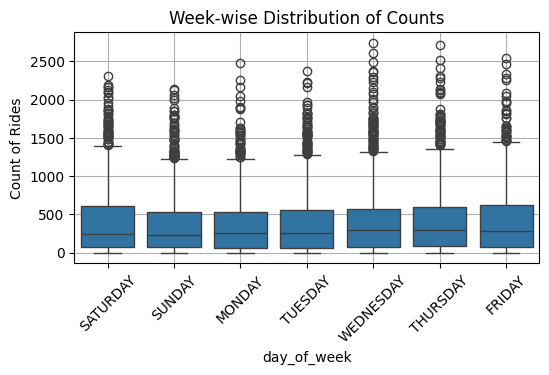

In [26]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=seasonality_df['day_of_week'], y='count', data=seasonality_df)
plt.title('Week-wise Distribution of Counts')
plt.xlabel('day_of_week')
plt.ylabel('Count of Rides')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()